# Data Analysis - Income and Houshold Size

Steps:

1 - Find percent change on cantonal or regional level
    Are there trends? Form groups of small communes vs big communes
    
2 - Extrapolate Income on communal level 2007 - 2016

3 - Analyse correlation(pearson R) between HH-size and Income on communal level

## Steps from Workbook DataAnalysis

In [103]:
%matplotlib inline
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [104]:
data_folder = './data/wrangled_data/'
data_incomes = './data/Incomes.csv'
map_folder = './data/map_data/'

In [105]:
# the cleaned and wrangled data from the notebook "Data Wrangling" is imported and numerous arrays are created
array_names = []

incomes = pd.read_csv(data_incomes)

for i in os.listdir(data_folder):
    globals()['%s' %i[:-4]] = pd.read_csv(data_folder + str(i))
    array_names.append(i[:-4])
    
#contains the list of all availble arrays
pd.DataFrame(array_names, columns=['Array Name']).sort_values(['Array Name']).head()

TypeError: 'str' object is not callable

### New

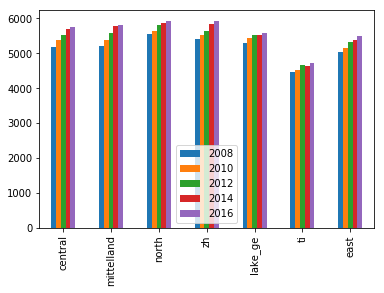

,2008,2010,2012,2014,2016
central,5185,5392,5520,5684,5756
mittelland,5200,5373,5583,5773,5803
north,5560,5647,5814,5856,5932
zh,5415,5513,5651,5846,5921
lake_ge,5284,5425,5517,5515,5583
ti,4460,4514,4664,4640,4722
east,5050,5143,5308,5367,5482


In [106]:
#create table for median incomes for all regions and years available
regions = ['central', 'mittelland', 'north', 'zh', 'lake_ge', 'ti', 'east']
wages_years = ['2008', '2010', '2012', '2014', '2016']

med_income_region = pd.DataFrame(columns=wages_years, index=regions)

for region in regions:
    for year in wages_years:
        str = region+year
        med_income_region.loc[region,year] = float(globals()['wages%s' %year+region][' Median'][1])

med_income.plot(kind='bar')
plt.show()

med_income_region

In [107]:
#create income dataframe with entries for 2008 as in 2007
cantons_path = './data/cantons.csv'
cantons = pd.read_csv(cantons_path)

header = ['Name', 'canton', '2008', '2010', '2012', '2014', '2016']
med_incomes = pd.DataFrame(columns=header, index=incomes.ID)
med_incomes[['Name','canton','2008']]=incomes[['NAME', 'KT', 'MEDREV']]
med_incomes= med_incomes.merge(cantons,left_on='canton', right_on='Kantonsnr').drop(columns=['canton'])

In [108]:
#extrapolate linearly from 2008(=2007) to dates
for ind in range(0,med_incomes.shape[0]): 
    for year in wages_years:
        region= med_incomes.loc[ind,'region']
        med_incomes.loc[ind,year] = med_incomes.loc[ind,'2008']*med_income_region.loc[region,year]/med_income_region.loc[region,'2008']     

In [110]:
med_incomes

,Name,2008,2010,2012,2014,2016,code,Kantonsnr,region
0,Affoltern am Albis,52.0200,52.9615,54.2872,56.1605,56.881,ZH,1,zh
1,Bonstetten,62.8786,64.0166,65.619,67.8833,68.7542,ZH,1,zh
2,Hausen am Albis,55.9826,56.9958,58.4225,60.4385,61.2138,ZH,1,zh
3,Hedingen,58.8480,59.913,61.4128,63.5319,64.347,ZH,1,zh
4,Kappel am Albis,56.7883,57.816,59.2633,61.3083,62.0948,ZH,1,zh
5,Knonau,54.5448,55.5319,56.922,58.8862,59.6417,ZH,1,zh
6,Maschwanden,50.7930,51.7122,53.0067,54.8358,55.5393,ZH,1,zh
7,Mettmenstetten,57.9394,58.988,60.4646,62.551,63.3535,ZH,1,zh
8,Obfelden,53.7722,54.7454,56.1157,58.0521,58.7969,ZH,1,zh
9,Ottenbach,57.3336,58.3712,59.8323,61.897,62.6911,ZH,1,zh


To Do:
- clean hh_sizes (better header,remove ()), change in datawrangling
- divide hhsizes / sum -> hh_percentage
- plot and take correlation between hhpercentage for different years and hh-sizes
